In [1]:
"""
Improved Synthetic Fraud Data Generation
==========================================
This script:
  • Loads the preprocessed fraud training data, scaler, and categorical artifacts.
  • Filters the data into fraud cases (for training the diffusion model) and non‐fraud data (for prior loss).
  • Computes the observed range for the engineered features.
  • Defines and trains an improved diffusion model with multiple loss components:
      - MSE loss (L_norm)
      - Prior loss (L_prior)
      - Triplet loss (L_triplet)
      - Engineered range loss (L_eng)
  • Generates synthetic numeric data via reverse diffusion.
  • Generates synthetic categorical data by sampling from empirical distributions.
  • Combines numeric and categorical features and evaluates the results.
  • Saves the synthetic dataset.

"""

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy import stats

# Set environment variable for KMP duplicate lib (if needed)
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# -----------------------------
# 1. Set File Paths and Load Data
# -----------------------------
# Update these file paths to match your directory structure.
x_train_path = r"Data/processed/X_train.csv"
y_train_path = r"Data/processed/y_train.csv"
scaler_path  = r"Data/processed/standard_scaler.pkl"
cat_vocab_path = r"Data/processed/cat_vocab.pkl"
cat_mapping_path = r"Data/processed/cat_mapping.pkl"

# Load training data and the scaler/categorical artifacts.
X_train_df = pd.read_csv(x_train_path)
y_train_df = pd.read_csv(y_train_path)
scaler = joblib.load(scaler_path)
cat_vocab = joblib.load(cat_vocab_path)
cat_mapping = joblib.load(cat_mapping_path)
print("Loaded StandardScaler and categorical artifacts.")

# Define feature lists (must match preprocessing)
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

# Create a fraud mask (we train on fraud cases) and non-fraud mask for prior loss.
y_train = y_train_df.iloc[:, 0]
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Filter numeric and categorical features for fraud cases.
X_train_num = X_train_df[numeric_features].loc[fraud_mask].values   # Note: numeric features are already scaled.
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values         # Categorical features (as integer codes).

# Also, store non-fraud numeric data (used for prior loss).
X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

# Create a DataFrame for fraud categorical data (to compute empirical distributions later).
fraud_cat_df = pd.DataFrame(X_train_cat, columns=cat_features)

Loaded StandardScaler and categorical artifacts.


In [2]:
# -----------------------------
# 2. Compute Engineered Feature Ranges
# -----------------------------
# Engineered features (extracted from datetime in preprocessing)
eng_features = ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Get indices for engineered features in the numeric_features list.
eng_indices = [numeric_features.index(feat) for feat in eng_features]

# Compute the observed minimum and maximum in standardized space.
eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eng_min = torch.tensor(eng_min_np, dtype=torch.float32).to(device)
eng_max = torch.tensor(eng_max_np, dtype=torch.float32).to(device)
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

# -----------------------------
# 3. Set Diffusion Hyperparameters and Loss Weights
# -----------------------------
T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)
# Adjusted loss weights; these may be tuned further.
w1 = 0.3         # Weight for prior loss (L_prior)
w2 = 0.7         # Weight for triplet loss (L_triplet)
lambda_eng = 0.5 # Weight for engineered range loss (L_eng)

Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817 ] max: [1.49563575 1.70671805 1.41547433 1.37969415]


In [3]:
# -----------------------------
# 4. Define Custom Dataset Class
# -----------------------------
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
    def __len__(self):
        return self.num_data.shape[0]
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat)

# -----------------------------
# 5. Define the Diffusion Model: CombinedNoisePredictor
# -----------------------------
class CombinedNoisePredictor(nn.Module):
    """
    This model takes:
      - Standard-scaled numeric features.
      - Embedded categorical features.
      - A normalized timestep (t/T_train).
    Returns the predicted noise vector.
    """
    def __init__(self, num_input_dim, cat_vocab_sizes, cat_embed_dim=2, hidden_dim=256):
        super(CombinedNoisePredictor, self).__init__()
        # Create an embedding for each categorical feature.
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        # Total dimension after embedding.
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        combined_input_dim = num_input_dim + cat_total_dim
        # Define fully connected layers.
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, combined_input_dim)
        self.activation = nn.LeakyReLU()
    def forward(self, x_num, x_cat, t):
        # Embed each categorical feature.
        embeds = []
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        x_cat_emb = torch.cat(embeds, dim=1)
        # Concatenate numeric features and embedded categorical features.
        x = torch.cat([x_num, x_cat_emb], dim=1)
        # Normalize the timestep; append it as an extra feature.
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        # Pass through the network.
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

# Create a dictionary of categorical vocabulary sizes.
cat_vocab_sizes = {col: cat_vocab[col] for col in cat_features}
print("Categorical vocabulary sizes:", cat_vocab_sizes)
num_input_dim = len(numeric_features)

# Initialize the diffusion model.
model = CombinedNoisePredictor(num_input_dim=num_input_dim,
                               cat_vocab_sizes=cat_vocab_sizes,
                               cat_embed_dim=2,
                               hidden_dim=256).to(device)


Categorical vocabulary sizes: {'merchant': 693, 'category': 14, 'gender': 2, 'street': 999, 'city': 906, 'state': 51, 'zip': 985, 'job': 497}


In [4]:
# -----------------------------
# 6. Compute Non-Fraud Data Statistics for Prior Loss
# -----------------------------
# Convert non-fraud numeric data to a tensor.
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
# Compute mean and standard deviation.
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

# -----------------------------
# 7. Define Loss Functions and Forward Diffusion
# -----------------------------
def forward_diffusion(x0, t):
    """
    Compute the forward diffusion process:
    x_t = sqrt(alpha_hat_t) * x0 + sqrt(1 - alpha_hat_t) * noise
    """
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    """MSE loss between predicted and true noise."""
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    """
    Prior loss to encourage x0 estimates to lie near the non-fraud distribution.
    This loss uses the normalized difference from non-fraud mean and std.
    """
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0, 1)
    prob = 1 - normal.cdf(z_abs)
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    """
    Triplet loss to encourage the estimated denoised value (anchor) to be closer
    to the original (positive) than to a random negative sample.
    """
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    """
    Loss to penalize the synthetic engineered features if they fall
    outside the observed [min, max] range.
    """
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

In [6]:
# -----------------------------
# 8. Train the Diffusion Model
# -----------------------------
# Create a DataLoader for training on the fraud dataset.
loader = DataLoader(fraud_dataset, batch_size=40, shuffle=True)
num_epochs = 250
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training …")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0_num, x0_cat = batch
        x0_num = x0_num.to(device)
        x0_cat = x0_cat.to(device)
        batch_size = x0_num.shape[0]
        
        # Sample a random timestep for each sample in the batch.
        t = torch.randint(0, T_train, (batch_size,), device=device)
        # Compute the forward diffusion (with noise).
        x_t_num, true_noise = forward_diffusion(x0_num, t)
        # Predict the noise with our diffusion model.
        pred_noise = model(x_t_num, x0_cat, t)
        # Only consider noise corresponding to numeric features.
        pred_noise_numeric = pred_noise[:, :num_input_dim]
        
        # Compute the various loss components.
        L_norm = compute_Lnorm(pred_noise_numeric, true_noise)
        L_prior = compute_Lprior(pred_noise_numeric)
        
        # One-step reverse diffusion to estimate denoised x0.
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        x0_est = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_numeric) / sqrt_alpha_hat_t
        
        # Sample non-fraud samples to compute triplet loss.
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        L_triplet = triplet_loss(x0_est, x0_num, negative_sample)
        
        # Compute engineered range loss for engineered features.
        x0_est_eng = x0_est[:, eng_indices]
        L_eng = engineered_range_loss(x0_est_eng, eng_min, eng_max)
        
        # Total loss
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet + lambda_eng * L_eng
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    
    avg_loss = epoch_loss / len(loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete.")
# Save the trained model.
model_save_path = r"D:/DS Northeastern/DS 5500 - Capstone/FraudFusion/Diffusion Models/fraud_diffuse_model_full_baseline.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)

Starting training …
Epoch [1/250], Loss: 0.3167
Epoch [10/250], Loss: 0.3148
Epoch [20/250], Loss: 0.3108
Epoch [30/250], Loss: 0.3140
Epoch [40/250], Loss: 0.3089
Epoch [50/250], Loss: 0.3161
Epoch [60/250], Loss: 0.3057
Epoch [70/250], Loss: 0.3086
Epoch [80/250], Loss: 0.3030
Epoch [90/250], Loss: 0.3008
Epoch [100/250], Loss: 0.3088
Epoch [110/250], Loss: 0.3033
Epoch [120/250], Loss: 0.3014
Epoch [130/250], Loss: 0.2926
Epoch [140/250], Loss: 0.2965
Epoch [150/250], Loss: 0.2931
Epoch [160/250], Loss: 0.2946
Epoch [170/250], Loss: 0.2868
Epoch [180/250], Loss: 0.2854
Epoch [190/250], Loss: 0.2852
Epoch [200/250], Loss: 0.2864
Epoch [210/250], Loss: 0.2812
Epoch [220/250], Loss: 0.2835
Epoch [230/250], Loss: 0.2802
Epoch [240/250], Loss: 0.2811
Epoch [250/250], Loss: 0.2796
Training complete.
Model saved to D:/DS Northeastern/DS 5500 - Capstone/FraudFusion/Diffusion Models/fraud_diffuse_model_full_baseline.pth


In [7]:
# -----------------------------
# 9. Define Functions for Synthetic Data Generation
# -----------------------------
def generate_synthetic_categoricals(fraud_cat_df, cat_features, num_samples):
    """
    Generate synthetic categorical features by sampling from the empirical distribution.
    Returns a DataFrame with synthetic categorical data.
    """
    synthetic_cat = {}
    for col in cat_features:
        # Get value frequencies and compute probabilities.
        value_counts = fraud_cat_df[col].value_counts(normalize=True).sort_index()
        categories = value_counts.index.values
        probabilities = value_counts.values
        synthetic_cat[col] = np.random.choice(categories, size=num_samples, p=probabilities)
    return pd.DataFrame(synthetic_cat)

def generate_synthetic_data(model, num_samples, fraud_cat_df, cat_features):
    """
    Generate synthetic numeric and categorical fraud data.
      - Numeric features are generated by reverse diffusion.
      - Categorical features are sampled from empirical distributions.
    Returns:
      synthetic_numeric: synthetic numeric array (normalized).
      synthetic_cat_df: DataFrame containing synthetic categorical features.
    """
    model.eval()
    with torch.no_grad():
        # Generate synthetic categorical features.
        synthetic_cat_df = generate_synthetic_categoricals(fraud_cat_df, cat_features, num_samples)
        # Convert the categorical DataFrame to a tensor.
        x_cat_input = torch.tensor(synthetic_cat_df.values, device=device, dtype=torch.long)
        
        # Initialize synthetic numeric generation using the statistics of fraud numeric data.
        noise = torch.randn(num_samples, num_input_dim).to(device)
        X_train_num_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        x_t_num = X_train_num_tensor.mean(dim=0, keepdim=True).repeat(num_samples, 1) + \
                  X_train_num_tensor.std(dim=0, keepdim=True).repeat(num_samples, 1) * noise
        
        # Reverse diffusion process.
        for t_step in reversed(range(1, T_train)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            pred_noise = model(x_t_num, x_cat_input, t)
            pred_noise_numeric = pred_noise[:, :num_input_dim]
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            # Add stochasticity in reverse diffusion.
            z = torch.randn_like(x_t_num) if t_step > 1 else torch.zeros_like(x_t_num)
            x_t_num = (x_t_num - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise_numeric) / sqrt_alpha_t \
                      + torch.sqrt(beta_t) * z
        
        # After reverse diffusion, clip engineered features to the observed range.
        x0_est_eng = x_t_num[:, eng_indices]
        x0_est_eng = torch.max(torch.min(x0_est_eng, eng_max.unsqueeze(0)), eng_min.unsqueeze(0))
        x_t_num[:, eng_indices] = x0_est_eng
        
        synthetic_numeric = x_t_num.cpu().numpy()
    return synthetic_numeric, synthetic_cat_df

Synthetic numeric samples shape (normalized): (1000, 11)
Synthetic categorical samples shape: (1000, 8)
Real Fraud Numeric Statistics (Original Scale):
               amt          lat         long     city_pop    merch_lat  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean      5.553833    38.720264   -90.184822     8.427249    38.711246   
std       1.627878     5.105657    14.214255     2.443052     5.140968   
min       0.722706    20.027100  -165.672302     3.178054    19.161783   
25%       5.479722    34.990601   -96.790901     6.679599    35.018204   
50%       5.958528    39.455799   -87.366699     7.940228    39.451233   
75%       6.802939    42.176701   -80.057297     9.893640    42.062038   
max       7.227692    66.693298   -67.950302    14.882529    67.188110   

        merch_long          age    trans_hour    trans_day  trans_month  \
count  6273.000000  6273.000000  6.273000e+03  6273.000000  6273.000000   
mean    -90.185539    53.622669

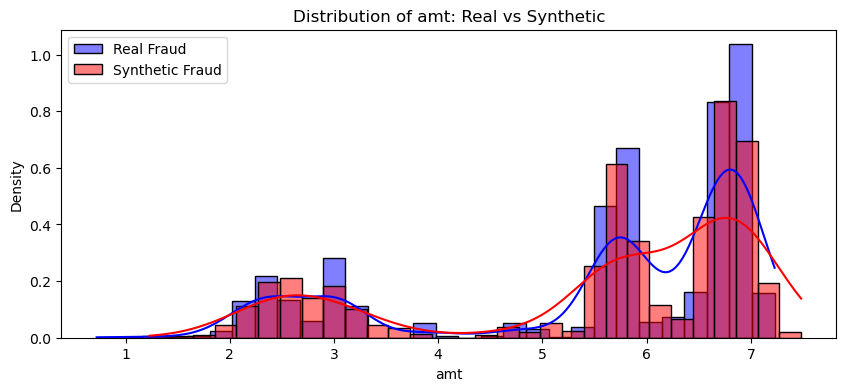

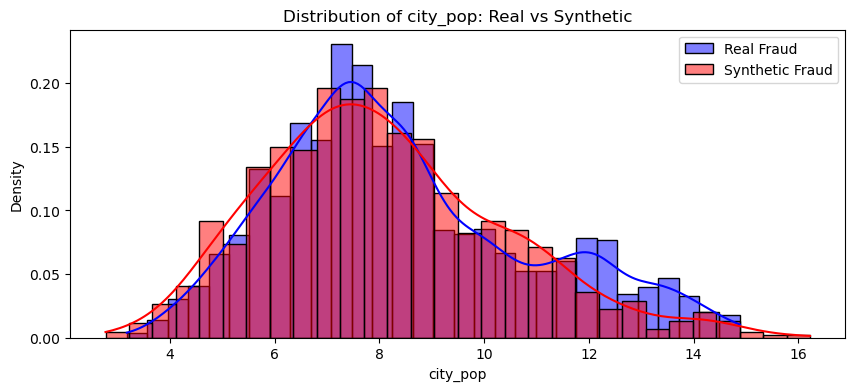

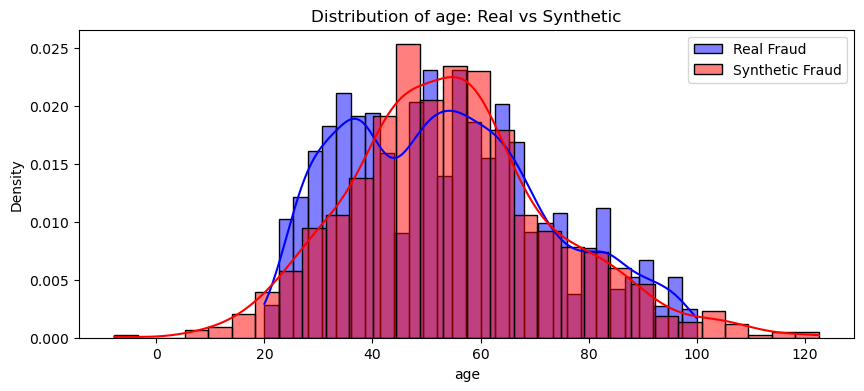

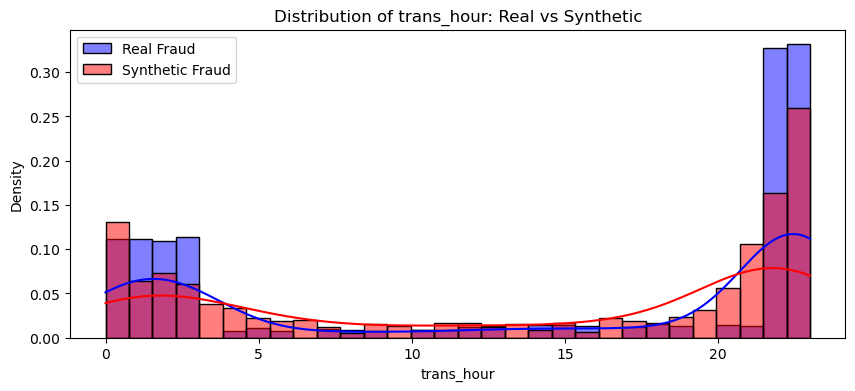

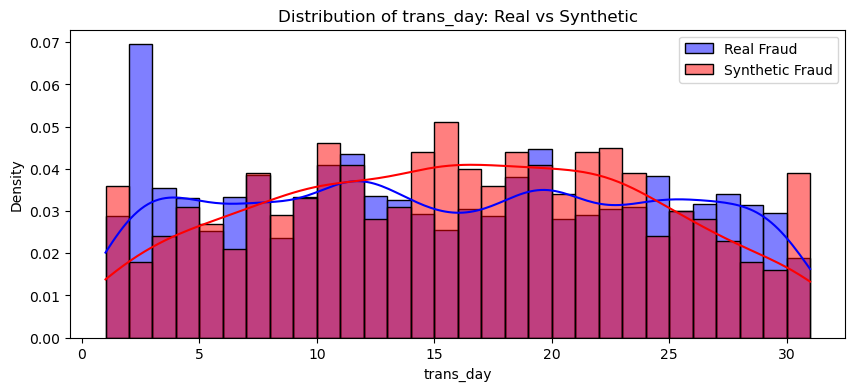

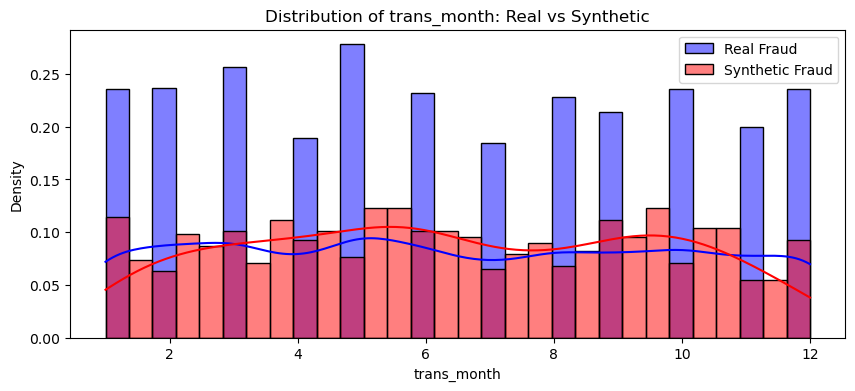

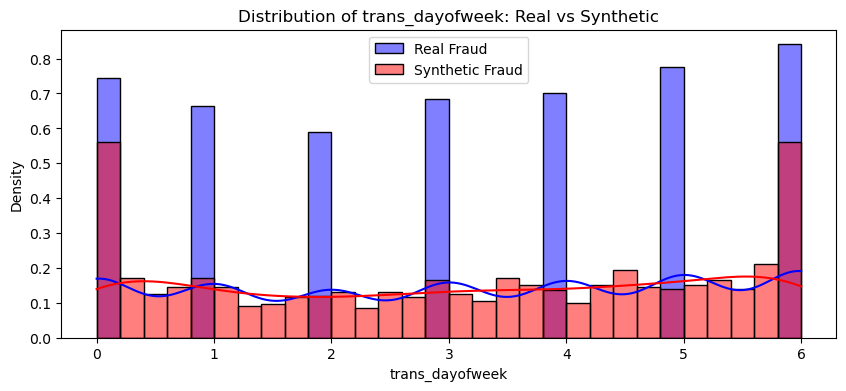

In [14]:
# -----------------------------
# 10. Generate Synthetic Data and Evaluate
# -----------------------------
num_synthetic = 1000  # Number of synthetic samples to generate.
synthetic_num_norm, synthetic_cat_df = generate_synthetic_data(model, num_synthetic, fraud_cat_df, cat_features)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat_df.shape)

# Convert synthetic numeric data back to original scale.
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm)

# Combine numeric and categorical synthetic data.
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

# Evaluate distributions: compare real vs synthetic numeric data.
X_train_num_original = scaler.inverse_transform(torch.tensor(X_train_num, dtype=torch.float32).cpu().numpy())
real_numeric_df = pd.DataFrame(X_train_num_original, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

# Plot comparisons for key features.
comparison_features = ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
for col in comparison_features:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

In [15]:
# -----------------------------
# Advanced Statistical Tests for Numeric Features
# -----------------------------
# List of numeric features to compare.
comparison_features = ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']

print("=== Advanced Statistical Tests for Numeric Features ===\n")

for col in comparison_features:
    # Extract data columns as arrays from the DataFrames
    real_data = real_numeric_df[col].dropna().values  # real numeric samples (original scale)
    syn_data = synthetic_numeric_df[col].dropna().values  # synthetic numeric samples (original scale)
  
    # 1. Kolmogorov-Smirnov (KS) Test: compares cumulative distributions.
    ks_stat, ks_p = stats.ks_2samp(real_data, syn_data)
    
    # 2. Anderson-Darling Test: non-parametric test for overall distribution fit.
    # Note: anderson_ksamp returns an object that includes a statistic and significance level.
    anderson_result = stats.anderson_ksamp([real_data, syn_data])
    
    # 3. Compute skewness and kurtosis (to assess asymmetry and tail-heaviness).
    real_skew = stats.skew(real_data)
    syn_skew = stats.skew(syn_data)
    real_kurt = stats.kurtosis(real_data)
    syn_kurt = stats.kurtosis(syn_data)
    
    print(f"Feature: {col}")
    print("-" * 60)
    print(f"KS test statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
    print(f"Anderson-Darling: Statistic = {anderson_result.statistic:.4f}, significance level = {anderson_result.significance_level:.4f}")
    print(f"Skewness -> Real: {real_skew:.4f}, Synthetic: {syn_skew:.4f}")
    print(f"Kurtosis -> Real: {real_kurt:.4f}, Synthetic: {syn_kurt:.4f}")
    print("-" * 60, "\n")

=== Advanced Statistical Tests for Numeric Features ===

Feature: amt
------------------------------------------------------------
KS test statistic: 0.0417, p-value: 0.0965
Anderson-Darling: Statistic = 4.8718, significance level = 0.0039
Skewness -> Real: -1.0827, Synthetic: -1.0147
Kurtosis -> Real: -0.3416, Synthetic: -0.4861
------------------------------------------------------------ 

Feature: city_pop
------------------------------------------------------------
KS test statistic: 0.0742, p-value: 0.0001
Anderson-Darling: Statistic = 9.4344, significance level = 0.0010
Skewness -> Real: 0.5893, Synthetic: 0.5715
Kurtosis -> Real: -0.2915, Synthetic: 0.1700
------------------------------------------------------------ 

Feature: age
------------------------------------------------------------
KS test statistic: 0.0979, p-value: 0.0000
Anderson-Darling: Statistic = 9.2445, significance level = 0.0010
Skewness -> Real: 0.3774, Synthetic: 0.4150
Kurtosis -> Real: -0.6331, Synthetic: 

C:\Users\raghu\AppData\Local\Temp\ipykernel_53016\1744071838.py:19: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson_result = stats.anderson_ksamp([real_data, syn_data])


In [16]:
real_cat_df = X_train_df.loc[fraud_mask, cat_features]

In [17]:
real_cat_df.head()

,merchant,category,gender,street,city,state,zip,job
270,490,6,0,740,687,15,732,421
382,93,7,1,960,349,24,947,17
439,46,6,0,332,324,27,331,257
659,166,0,0,192,191,43,192,167
977,319,6,0,799,741,30,790,427


In [18]:
# -----------------------------
# Advanced Tests for Categorical Features
# -----------------------------
# For categorical features we compare frequency distributions.
print("=== Advanced Statistical Tests for Categorical Features ===\n")

# real_cat_df: DataFrame of real categorical data (fraud cases)
# synthetic_full_df: DataFrame that contains synthetic categorical columns (same names as cat_features)

cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

for col in cat_features:
    # Calculate frequency distributions for real and synthetic data.
    real_counts = real_cat_df[col].value_counts().sort_index()
    syn_counts = synthetic_full_df[col].value_counts().sort_index()
    
    # Align indices: make sure both series have the same categories (fill missing ones with 0)
    all_index = real_counts.index.union(syn_counts.index)
    real_counts = real_counts.reindex(all_index, fill_value=0)
    syn_counts = syn_counts.reindex(all_index, fill_value=0)
    
    # Chi-Square Test: Tests if the observed frequencies in synthetic data match the expected real frequencies.
    # Here we adjust expected counts by scaling real proportions to the synthetic sample size.
    expected = real_counts.values * (syn_counts.sum() / real_counts.sum())
    chi2_stat, chi2_p = stats.chisquare(f_obs=syn_counts.values, f_exp=expected)
    
    # KL Divergence: Measures how different two probability distributions are.
    real_probs = real_counts / real_counts.sum()
    syn_probs = syn_counts / syn_counts.sum()
    kl_div = stats.entropy(real_probs, syn_probs)
    
    print(f"Categorical Feature: {col}")
    print("-" * 60)
    print(f"Chi-square Statistic: {chi2_stat:.4f}, p-value: {chi2_p:.4f}")
    print(f"KL Divergence: {kl_div:.4f}")
    print("-" * 60, "\n")

=== Advanced Statistical Tests for Categorical Features ===

Categorical Feature: merchant
------------------------------------------------------------
Chi-square Statistic: 753.3700, p-value: 0.0136
KL Divergence: inf
------------------------------------------------------------ 

Categorical Feature: category
------------------------------------------------------------
Chi-square Statistic: 6.1376, p-value: 0.9410
KL Divergence: 0.0029
------------------------------------------------------------ 

Categorical Feature: gender
------------------------------------------------------------
Chi-square Statistic: 0.0001, p-value: 0.9931
KL Divergence: 0.0000
------------------------------------------------------------ 

Categorical Feature: street
------------------------------------------------------------
Chi-square Statistic: 908.7568, p-value: 0.9298
KL Divergence: inf
------------------------------------------------------------ 

Categorical Feature: city
-------------------------------

Summary statistics for engineered features:
         trans_hour     trans_day   trans_month  trans_dayofweek
count  1.204055e+06  1.204055e+06  1.204055e+06     1.204055e+06
mean   9.228478e-04 -2.586803e-05  7.660272e-04     2.291956e-04
std    9.996905e-01  9.996430e-01  9.995851e-01     9.997814e-01
min   -1.878901e+00 -1.673090e+00 -1.796249e+00    -1.350082e+00
25%   -8.518678e-01 -8.844684e-01 -9.203242e-01    -8.951191e-01
50%    1.751650e-01  1.681383e-02 -4.439973e-02     1.480623e-02
75%    9.087599e-01  9.180961e-01  8.315247e-01     9.247315e-01
max    1.495636e+00  1.706718e+00  1.415474e+00     1.379694e+00 

Feature: trans_hour
Unique values: [-1.8789006230791456, -1.7321816504543472, -1.5854626778295489, -1.4387437052047505, -1.292024732579952, -1.1453057599551535, -0.9985867873303552, -0.8518678147055566, -0.7051488420807582, -0.5584298694559597, -0.4117108968311613, -0.2649919242063628, -0.1182729515815644, 0.028446021043234, 0.1751649936680324, 0.3218839662928309, 0.

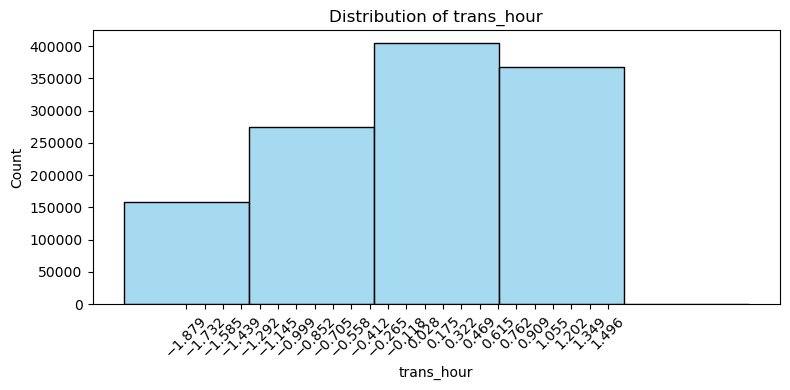

Feature: trans_day
Unique values: [-1.6730903889293849, -1.5604301077318363, -1.447769826534288, -1.3351095453367396, -1.2224492641391913, -1.109788982941643, -0.9971287017440944, -0.8844684205465462, -0.7718081393489978, -0.6591478581514495, -0.5464875769539012, -0.4338272957563528, -0.3211670145588045, -0.2085067333612561, -0.0958464521637078, 0.0168138290338405, 0.1294741102313888, 0.2421343914289372, 0.3547946726264855, 0.4674549538240338, 0.5801152350215822, 0.6927755162191306, 0.8054357974166789, 0.9180960786142272, 1.0307563598117755, 1.1434166410093238, 1.2560769222068722, 1.3687372034044205, 1.4813974846019689, 1.5940577657995172, 1.7067180469970655] 



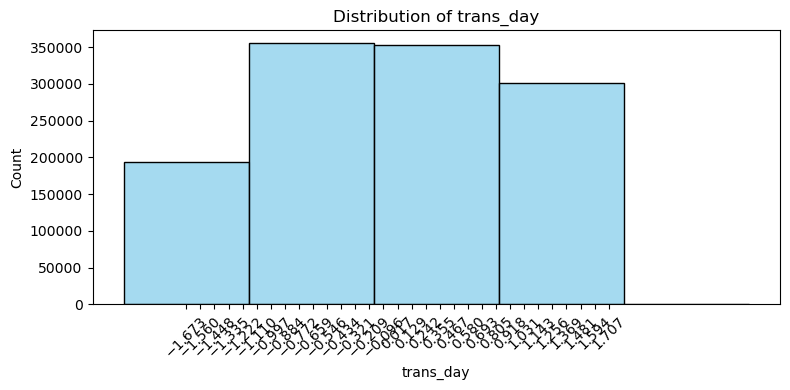

Feature: trans_month
Unique values: [-1.796248609354714, -1.504273796807613, -1.212298984260512, -0.9203241717134109, -0.6283493591663099, -0.3363745466192088, -0.0443997340721077, 0.2475750784749933, 0.5395498910220944, 0.8315247035691954, 1.1234995161162964, 1.4154743286633975] 



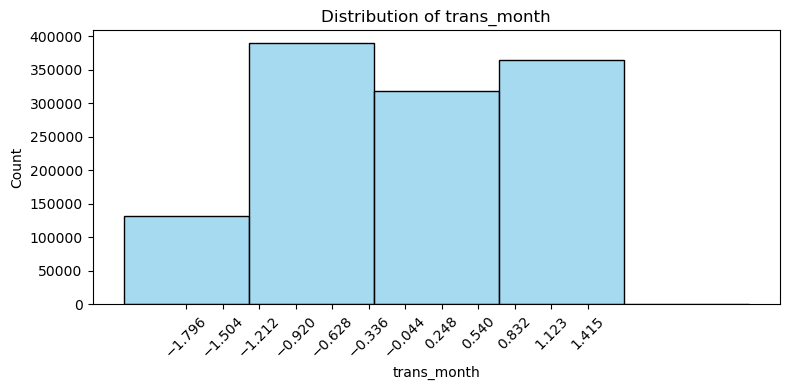

Feature: trans_dayofweek
Unique values: [-1.3500816986193038, -0.895119056410515, -0.4401564142017262, 0.0148062280070625, 0.4697688702158514, 0.9247315124246402, 1.379694154633429] 



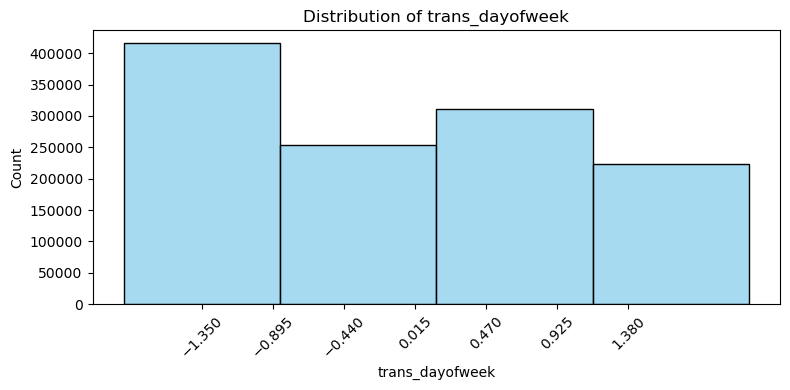

In [19]:
"""
Inspect Engineered Features for Synthetic Data Generation

This script loads the preprocessed training CSV (X_train.csv) that contains your engineered
time features, and it prints summary statistics, unique values, as well as plots histograms.
These features include:
    - trans_hour   (should be between 0 and 23)
    - trans_day    (typically 1-31, but depends on the month)
    - trans_month  (1 to 12)
    - trans_dayofweek (e.g., 0 to 6 or 1 to 7)

By understanding precisely how these values look before they are used by the model, you can
better decide on any necessary post-processing or diffusion model improvements.
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Update the file path as needed
x_train_path = r"Data/processed/X_train.csv"
X_train_df = pd.read_csv(x_train_path)

# List of engineered features
engineered_features = ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']

# Print summary statistics
print("Summary statistics for engineered features:")
print(X_train_df[engineered_features].describe(), "\n")

# For each engineered feature, print unique values and plot the distribution
for feature in engineered_features:
    print(f"Feature: {feature}")
    unique_vals = sorted(X_train_df[feature].unique())
    print("Unique values:", unique_vals, "\n")
    
    plt.figure(figsize=(8, 4))
    sns.histplot(X_train_df[feature], bins=len(unique_vals), discrete=True, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(unique_vals, rotation=45)
    plt.tight_layout()
    plt.show()

In [21]:
synthetic_full_df.columns

Index(['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age',
       'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek', 'merchant',
       'category', 'gender', 'street', 'city', 'state', 'zip', 'job'],
      dtype='object')

In [22]:
synthetic_full_df

,amt,lat,long,city_pop,merch_lat,merch_long,age,trans_hour,trans_day,trans_month,trans_dayofweek,merchant,category,gender,street,city,state,zip,job
0,7.340504,42.732628,-87.118866,5.569527,42.470116,-87.176987,85.730522,2.300000e+01,16.090115,4.564218,2.530252e+00,447,6,0,396,602,19,104,424
1,6.911973,41.019279,-89.049690,9.240004,41.124016,-89.802376,54.391819,2.409914e+00,19.121933,6.672118,6.516117e-08,207,6,0,260,45,15,582,480
2,7.021863,43.383545,-72.024139,4.827182,42.676620,-74.691292,28.364874,1.304846e+00,24.436361,1.000000,6.516117e-08,105,6,0,598,900,34,935,130
3,5.658783,36.578373,-86.224548,8.209826,37.183281,-85.280411,62.154491,1.678718e+01,26.530378,4.536798,1.151094e+00,307,1,1,647,82,7,247,424
4,5.715441,45.317841,-90.088188,8.937454,46.632236,-90.102242,45.379620,3.545246e-08,9.419079,10.384339,5.156380e+00,292,1,1,248,705,18,374,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.963841,40.351646,-75.217209,10.083709,39.999882,-74.690765,23.830286,2.300000e+01,22.374256,4.661865,7.157384e-01,187,9,0,867,751,13,827,166
996,5.549983,44.332024,-91.225739,12.950832,43.789761,-89.802361,29.220127,5.024462e-01,31.000000,5.130006,3.481725e+00,177,1,1,894,525,18,608,39
997,6.812326,39.321507,-112.632660,8.296128,39.401939,-113.333336,86.659157,2.300000e+01,26.804523,6.377003,3.769201e+00,21,0,0,460,81,29,531,211
998,3.050426,47.067005,-100.367271,5.503456,46.754837,-100.631332,42.097637,2.056672e+01,13.521932,9.392540,3.406792e+00,685,12,1,510,792,47,674,278


=== Range Comparison ===

lat:
Real data range: [20.0271, 66.6933]
Synthetic range: [23.1794, 53.2719]

long:
Real data range: [-165.6723, -67.9503]
Synthetic range: [-130.8989, -67.1461]

merch_lat:
Real data range: [19.0278, 67.5103]
Synthetic range: [22.3181, 52.8903]

merch_long:
Real data range: [-166.6712, -66.9509]
Synthetic range: [-131.0757, -67.5864]

=== Coordinate Validation ===
Percentage of coordinates within US bounds:

Real Data:
Valid latitudes: 99.64%
Valid longitudes: 99.64%

Synthetic Data:
Valid latitudes: 99.30%
Valid longitudes: 99.60%

=== Distance Analysis ===
Customer-Merchant Distance Statistics (km):

Real data:
count    1.296675e+06
mean     7.611465e+01
std      2.911693e+01
min      2.225452e-02
25%      5.533491e+01
50%      7.823175e+01
75%      9.850327e+01
max      1.521172e+02
dtype: float64

Synthetic data:
count    1000.000000
mean      118.102349
std        69.543606
min         1.783126
25%        65.662193
50%       108.610455
75%       160.7384

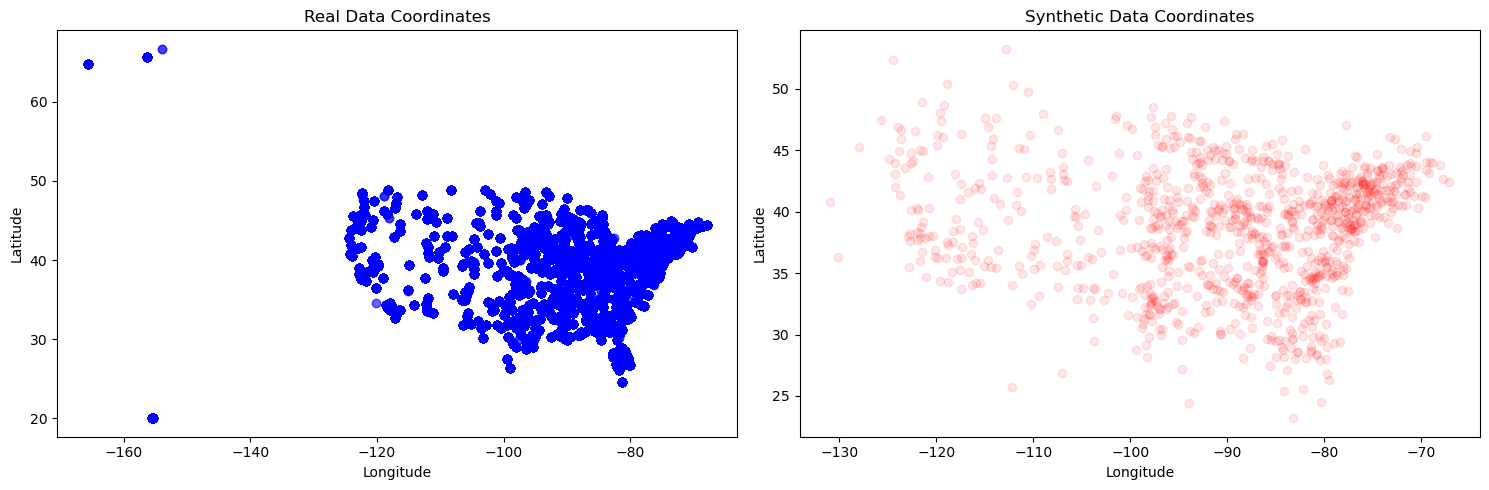

In [26]:
# Load the original data
original_data = pd.read_csv("Data/Sparkov/fraudTrain.csv")
processed_data = pd.read_csv("Data/processed/X_train.csv")

# Let's analyze the geographical patterns
def analyze_geo_patterns(real_df, synthetic_df):
    # Check ranges
    print("=== Range Comparison ===")
    geo_cols = ['lat', 'long', 'merch_lat', 'merch_long']
    for col in geo_cols:
        print(f"\n{col}:")
        print(f"Real data range: [{real_df[col].min():.4f}, {real_df[col].max():.4f}]")
        print(f"Synthetic range: [{synthetic_df[col].min():.4f}, {synthetic_df[col].max():.4f}]")
    
    # Check for valid US coordinates
    print("\n=== Coordinate Validation ===")
    print("Percentage of coordinates within US bounds:")
    us_bounds = {
        'lat': (24.396308, 49.384358),  # Approximate US latitude range
        'long': (-125.000000, -66.934570)  # Approximate US longitude range
    }
    
    for df, name in [(real_df, 'Real'), (synthetic_df, 'Synthetic')]:
        print(f"\n{name} Data:")
        valid_lat = ((df['lat'] >= us_bounds['lat'][0]) & 
                    (df['lat'] <= us_bounds['lat'][1])).mean() * 100
        valid_long = ((df['long'] >= us_bounds['long'][0]) & 
                     (df['long'] <= us_bounds['long'][1])).mean() * 100
        print(f"Valid latitudes: {valid_lat:.2f}%")
        print(f"Valid longitudes: {valid_long:.2f}%")
    
    # Check merchant-customer distance distribution
    print("\n=== Distance Analysis ===")
    from math import radians, sin, cos, sqrt, atan2
    
    def haversine_distance(row):
        R = 6371  # Earth's radius in km
        lat1, lon1 = radians(row['lat']), radians(row['long'])
        lat2, lon2 = radians(row['merch_lat']), radians(row['merch_long'])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c
    
    real_distances = real_df.apply(haversine_distance, axis=1)
    synthetic_distances = synthetic_df.apply(haversine_distance, axis=1)
    
    print("Customer-Merchant Distance Statistics (km):")
    print("\nReal data:")
    print(real_distances.describe())
    print("\nSynthetic data:")
    print(synthetic_distances.describe())

# Run the analysis
analyze_geo_patterns(original_data, synthetic_full_df)

# Visualize the distributions
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(original_data['long'], original_data['lat'], 
           alpha=0.1, c='blue', label='Real')
plt.title('Real Data Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(122)
plt.scatter(synthetic_full_df['long'], synthetic_full_df['lat'], 
           alpha=0.1, c='red', label='Synthetic')
plt.title('Synthetic Data Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()